In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Multi-Agent Research System

This notebook combines all the previous components into a single system.

Here is our overall research flow:

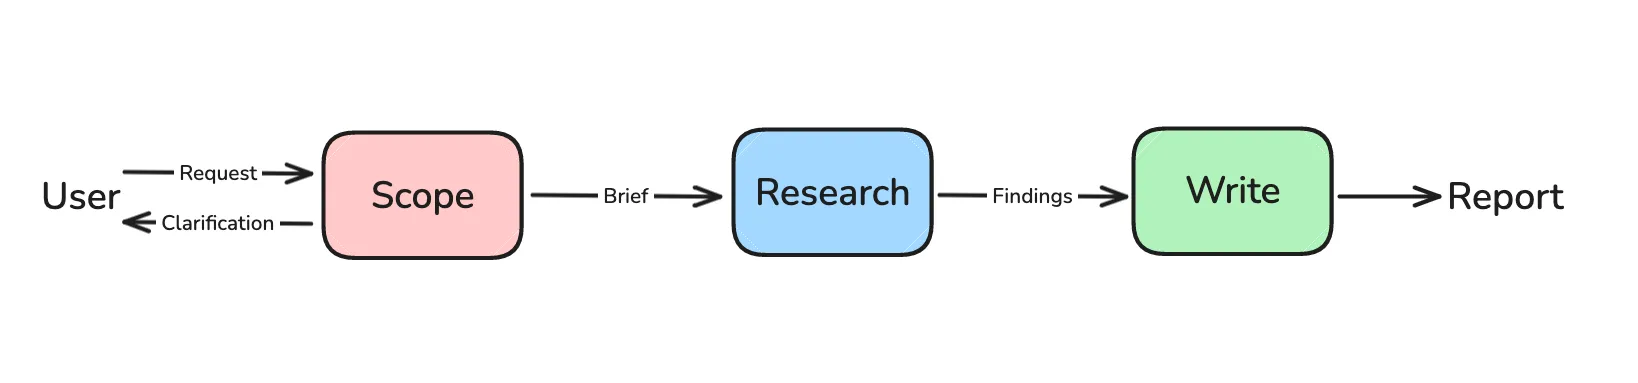

We've built research scoping and multi-agent research in previous notebooks.

Now, we'll add the final report generation step.

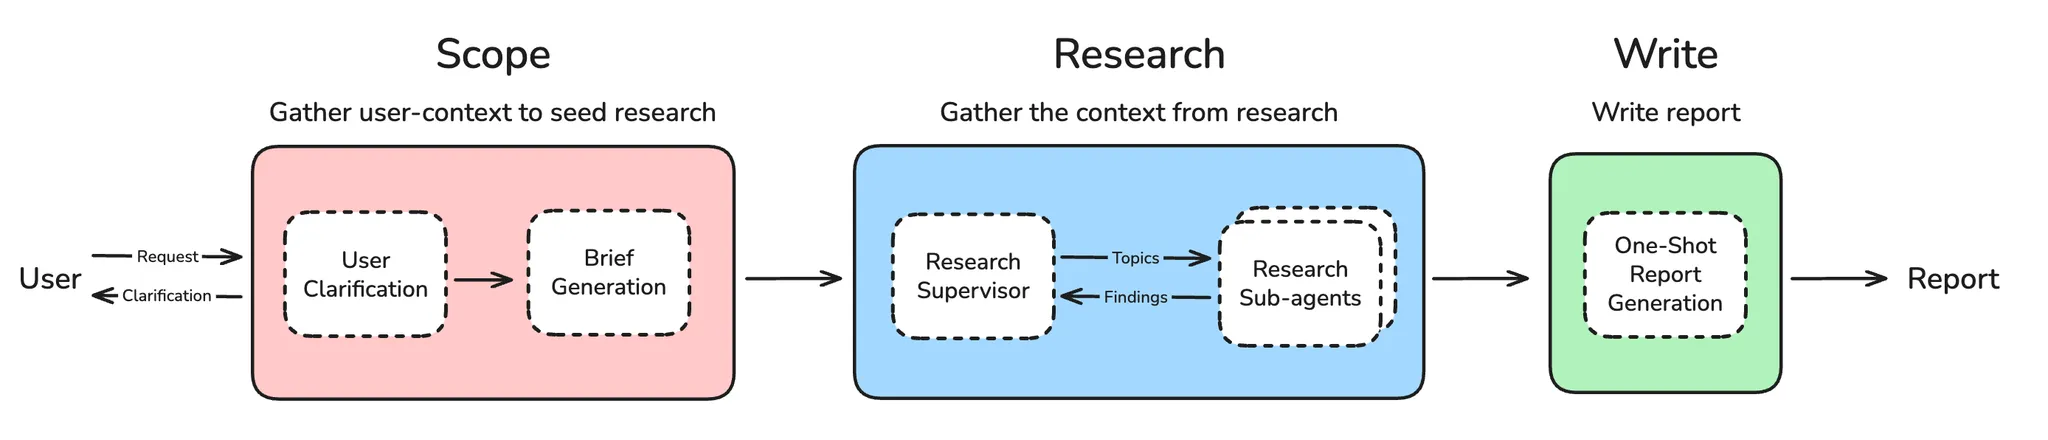

### Agent 

We simply can re-use the components we've already built.

In [6]:
%%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ===== Config =====

from langchain.chat_models import init_chat_model
writer_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== FINAL REPORT GENERATION =====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile the full workflow
agent = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_full.py


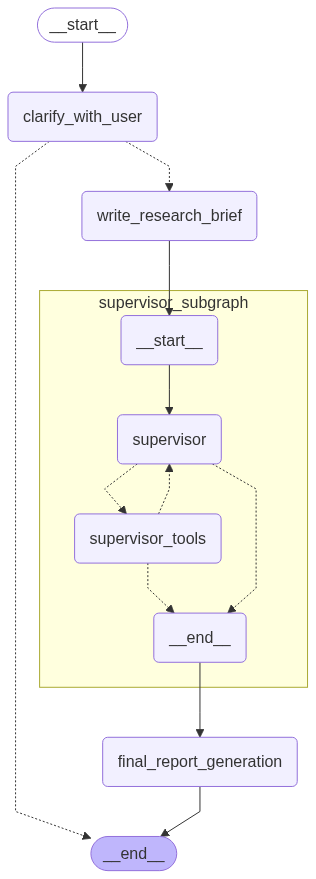

In [7]:
# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

LangGraph has a default recursion limit of 25 steps to prevent infinite loops. For complex research workflows that require iterative rounds of research, this limit needs to be increased. As explained in [LangGraph's troubleshooting guide](https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/), the recursion limit counts every node execution in the graph. In our multi-agent research system:

- **Single Research Agent**: May take 8-12 steps for tool calls and compression
- **Multi-Agent Supervisor**: Each sub-agent spawned adds additional steps
- **Iterative Research**: Supervisor may conduct multiple rounds of research to fill gaps
- **Full Workflow**: Includes scoping, research brief generation, supervision, and report generation

We set the recursion limit to **50** to accommodate:
- Complex research topics requiring multiple research rounds
- Parallel sub-agent execution
- Deep research with many tool calls
- Complete workflow execution from scoping to final report

This allows the supervisor to conduct iterative rounds of research when initial findings have gaps, ensuring comprehensive coverage of complex research topics.

In [8]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by "Gemini"? Are you referring to Google's Gemini AI model, or another system?  │
│ Also, by "OpenAI Deep Research agents," do you mean OpenAI's advanced research models (like GPT-4 or GPT-5), or │
│ a specific research agent product?                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [9]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Yes the specific Deep Research products.")]}, config=thread)

In [10]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by "Gemini"? Are you referring to Google's Gemini AI model, or another system?  │
│ Also, by "OpenAI Deep Research agents," do you mean OpenAI's advanced research models (like GPT-4 or GPT-5), or │
│ a specific research agent product?                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Yes the specific Deep Research products.                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for clarifying. I understand that you would like a comparison between Google's Gemini AI model and    │
│ OpenAI's specific Deep Research products. I will now begin the research and provide a detailed comparison based │
│ on the latest available information.                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # Comprehensive Comparison of Google Gemini AI vs. OpenAI Deep Research Products      │
│                                                                                                                 │
│ ## Introduction                                                                                                 │
│                                                                                                                 │
│ This report provides a detailed comparison between Google’s Gemini AI model family and OpenAI’s Deep Research   │
│ products, focusing on key attributes including model architecture, capabilities, intended use cases,            │
│ performance benchmarks, integration options, and real-world applications. The analysis draws from official      │
│ documentation, research papers, and product announcements to ensure accuracy and up-to-date information (as of  │
│ August 2025). Additional factors such as pricing, safety, flexibility, and ecosystem integration are also       │
│ addressed.                                                                                                      │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## Overview of Google Gemini AI                                                                                 │
│                                                                                                                 │
│ ### Model Architecture and Technical Specifications                                                             │
│                                                                                                                 │
│ - **Gemini models** leverage advanced transformer architectures with innovations such as sparse                 │
│ mixture-of-experts and natively multimodal processing, allowing seamless management of text, images, audio,     │
│ video, code, and documents in a single unified model. This design enables superior efficiency and high          │
│ performance across a wide variety of tasks.                                                                     │
│ - Key variants:                                                                                                 │
│   - **Gemini 2.5 Pro**: Top-tier reasoning and multimodal model, with up to 1,048,576 input token context and   │
│ 65,535 output tokens. Processes inputs like text, code, images, audio, PDF, and video; known for                │
│ state-of-the-art reasoning and code generation.                                                                 │
│   - **Gemini 2.5 Flash / Flash-Lite**: Models optimized for cost and latency; ideal for high-volume,            │
│ low-latency applications.                                                                                       │
│   - **Gemma**: A family of lightweight, open models (up to 27B params) for edge and local device use,           │
│ emphasizing ease of deployment and responsible AI[1][2][6].                                                     │
│                                                                                                                 │
│ ### Capabilities                                                                                                │
│                                                                                                                 │
│ - **Multimodal understanding**: Native handling of a broad range of inputs (text, images, video, audio, code)   │
│ with a single model streamlines tasks that require inte

In [11]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Comprehensive Comparison of Google Gemini AI vs. OpenAI Deep Research Products                  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                   Introduction                                                    

This report provides a detailed comparison between Google’s Gemini AI model family and OpenAI’s Deep Research      
products, focusing on key attributes including model architecture, capabilities, intended use cases, performance   
benchmarks, integration options, and real-world applications. The analysis draws from official documentation,      
research papers, and product announcements to ensure accuracy and up-to-date information (as of August 2025).      
Additional factors such as pricing, safety, flexibility, and ecosystem integration are also addressed.             

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                           Overview of Google Gemini AI                                            

                                  Model Architecture and Technical Specifications                                  

 • Gemini models leverage advanced transformer architectures with innovations such as sparse mixture-of-experts and
   natively multimodal processing, allowing seamless management of text, images, audio, video, code, and documents 
   in a single unified model. This design enables superior efficiency and high performance across a wide variety of
   tasks.                                                                                                          
 • Key variants:                                                                                                   
    • Gemini 2.5 Pro: Top-tier reasoning and multimodal model, with up to 1,048,576 input token context and 65,535 
      output tokens. Processes inputs like text, code, images, audio, PDF, and video; known for state-of-the-art   
      reasoning and code generation.                                                                               
    • Gemini 2.5 Flash / Flash-Lite: Models optimized for cost and latency; ideal for high-volume, low-latency     
      applications.                                                                                                
    • Gemma: A family of lightweight, open models (up to 27B params) for edge and local device use, emphasizing    
      ease of deployment and responsible AI[1][2][6].                                                              

                                                   Capabilities                                                    

 • Multimodal understanding: Native handling of a broad range of inputs (text, images, video, audio, code) with a  
   single model streamlines tasks that require integration across different media.                                 
 • Long-context reasoning: Particularly strong with large context windows—processing up to 1 million tokens or     
   multi-hour videos, excelling in use cases demanding synthesis across extensive datasets.                        
 • Advanced code and math reasoning: State-of-the-art performance on coding benchmarks (e.g., HumanEval),          
   mathematical tasks, and structured outputs.                                                                     
 • Factual grounding and function calling: Integrates Google's Search for real-time information grounding and      
   supports structured outputs/function execution.                                                                 
 • Safety mechanisms: Includes automated red teaming, memorization analysis, robust alignment standards, and safety
   checkers like ShieldGemma for image content 

We can see the trace [here](https://smith.langchain.com/public/86ebdc25-4595-4040-be1e-a8e30052786b/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

The files we wrote with `%%writefile` to `src/deep_research_from_scratch/` during the all the notebooks create the files for our application:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

This agent has been added to the `langgraph.json` file, so you can select `research_agent_full` in the dropdown menu:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```